# Math Question Answer Verification Competition

## Starter Code

Borrowed from [official Unsloth implementation](https://colab.research.google.com/drive/1Ys44kVvmeZtnICzWz0xgpRnrIOjZAuxp?usp=sharing#scrollTo=MKX_XKs_BNZR)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# %%capture
# This cell will take time
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.0/162.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Found existing installation: unsloth 2024.11.6
Uninstalling unsloth-2024.11.6:
  Successfully uninstalled unsloth-2024.11.6
  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-4rx41htq/unsloth_625743b9e14c4b56b17a5ad7b688939c
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-4rx41htq/unsloth_625743b9e14c4b56b17a5ad7b688939c
  Resolved https://github.com/unslothai/unsloth.git to commit d8ff860c842095f4729fdd1d5aedf567a9e2c4da
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2024.11.6-py3-none-any.whl size=161268 sha256=396262b312464b1057f959307f74e1fb7d19e5ecb628aa8a6f5bf5e7d35a5c66
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ca8zusd/wheels/ed/d4/e9/76fb290ee3df0a5fc21ce5c2c788e29e9607a2353d8342fd0d
Successfully built unsloth


In [10]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # RoPE scaling, so we maintain unchanged here
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.


In [11]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2024.11.6: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu124. CUDA = 8.9. CUDA Toolkit = 12.4.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


## Load model and wrap with LoRA adapters

In [13]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    # choose the modules: attention layers ["q_proj", "v_proj"], feed forward layers ["down_proj", "up_proj"]
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    # usally 2 * rank
    lora_alpha = 32,
    # add some dropout to prevent overfitting
    lora_dropout = 0.1, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.1.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2024.11.6 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


## Competition dataset

In [3]:
# download and load competition dataset

from datasets import load_dataset
dataset = load_dataset("ad6398/nyu-dl-teach-maths-comp")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.09k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [4]:
# Print dataset details
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['question', 'is_correct', 'answer', 'solution'],
        num_rows: 1000000
    })
    test: Dataset({
        features: ['question', 'is_correct', 'answer', 'solution'],
        num_rows: 10000
    })
})


In [5]:
# Check the columns and a sample row
print(dataset["train"].column_names)
print(dataset["train"][0])

['question', 'is_correct', 'answer', 'solution']
{'question': 'What is the radius of the circle inscribed in triangle $ABC$ if $AB = 22, AC=12,$ and $BC=14$? Express your answer in simplest radical form.', 'is_correct': True, 'answer': '3.16227766016838', 'solution': "The circle is inscribed in a triangle, and we know the sides of the triangle.\nTo use the inradius formula, we need to know the area of the triangle.\nWe can use Heron's formula to calculate the area.\n<llm-code>\nimport math\nfrom sympy import *\n\nAB, AC, BC = 22, 12, 14\n\n# Calculate the semiperimeter and area using Heron's formula\ns = (AB + AC + BC) / 2\nK = sqrt(s * (s - AB) * (s - AC) * (s - BC))\n\nprint(K)\n</llm-code>\n<llm-code-output>\n75.8946638440411\n</llm-code-output>\nLet's now use the formula for the radius of the inscribed circle.\n<llm-code>\nr = K / s\nprint(r)\n</llm-code>\n<llm-code-output>\n3.16227766016838\n</llm-code-output>\nThe answer is \\boxed{3.16227766016838}"}


Since there's no validation sets in the given dataset, we need to create one

In [6]:
# Create a validation split (80% train, 20% validation)
train_val_split = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_data = train_val_split["train"]
validation_data = train_val_split["test"]

In [7]:
# Check the sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(validation_data)}")
print(f"Test set size: {len(dataset['test'])}")

Training set size: 800000
Validation set size: 200000
Test set size: 10000


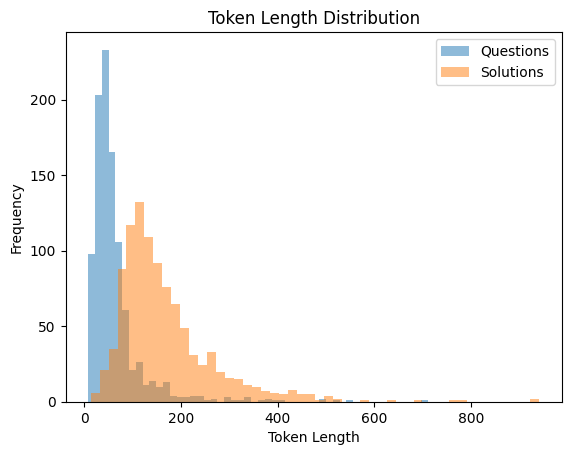

Mean question length: 63.6
95th percentile question length: 164.0
Mean solution length: 168.724
95th percentile solution length: 365.14999999999986


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Analyze token lengths for the "question" and "solution" fields
train_data_sample = train_data.select(range(1000))  # Sample to speed up analysis

question_lengths = [len(tokenizer(question)["input_ids"]) for question in train_data_sample["question"]]
solution_lengths = [len(tokenizer(solution)["input_ids"]) for solution in train_data_sample["solution"]]

# Plot token length distributions
plt.hist(question_lengths, bins=50, alpha=0.5, label="Questions")
plt.hist(solution_lengths, bins=50, alpha=0.5, label="Solutions")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.legend()
plt.title("Token Length Distribution")
plt.show()

# Statistics
print(f"Mean question length: {np.mean(question_lengths)}")
print(f"95th percentile question length: {np.percentile(question_lengths, 95)}")
print(f"Mean solution length: {np.mean(solution_lengths)}")
print(f"95th percentile solution length: {np.percentile(solution_lengths, 95)}")

In [14]:
prompt = """You are a great mathematician and you are tasked with finding if an answer to a given maths question is correct or not. Yout response should be 'True' if correct, otherwise 'False'. Below is Question and Answer.


### Question:
{}

### Answer:
{}

### Solution:
{}

### Output:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    question = examples["question"]
    ans       = examples["answer"]
    solution = examples["solution"]
    output      = examples["is_correct"]
    texts = []
    for instruction, input, sol, output in zip(question, ans, solution, output):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = prompt.format(instruction, input, sol, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }




In [16]:
# Process the training dataset and generate prompt for each datapoint
train_dataset = train_data.map(formatting_prompts_func, batched = True)
# Process the validation dataset
validation_dataset = validation_data.map(formatting_prompts_func, batched=True)

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

In [17]:
#print a smaple training example
train_dataset['text'][0]

'You are a great mathematician and you are tasked with finding if an answer to a given maths question is correct or not. Yout response should be \'True\' if correct, otherwise \'False\'. Below is Question and Answer.\n\n\n### Question:\nIf two lines $l$ and $m$ have equations $y = -x + 6$, and $y = -4x + 6$, what is the probability that a point randomly selected in the 1st quadrant and below $l$ will fall between $l$ and $m$? Express your answer as a decimal to the nearest hundredth.\n\n[asy]\nimport cse5; import olympiad;\nsize(150);\nadd(grid(8,8));\ndraw((0,0)--(8,0),linewidth(1.2));\ndraw((0,0)--(0,8),linewidth(1.2));\nlabel("$x$",(8,0),E);\nlabel("$y$",(0,8),N);\ndraw((6,0)--(0,6)--(3/2,0));\nlabel("$l$",(6,0)--(0,6),NE);\nlabel("$m$",(0,6)--(3/2,0),NE);\n[/asy]\n\n### Answer:\n\\frac{S}{T}\n\n### Solution:\nLet\'s first calculate the areas under $l$ and $m$ and in the first quadrant.\nThe triangle under $l$ has the base of length $M$ and height of length $M$, so its area is $\\fr

In [31]:
small_train_dataset = train_dataset.shuffle(seed=42).select(range(int(len(train_dataset) * 0.01)))
small_validation_dataset = validation_dataset.shuffle(seed=42).select(range(int(len(validation_dataset) * 0.001)))
print(f"Training set size: {len(small_train_dataset)}")
print(f"Validation set size: {len(small_validation_dataset)}")

Training set size: 8000
Validation set size: 200


## SFT

In [32]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

training_args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 100,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 1000,
        learning_rate = 1e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 10,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
        eval_steps=10,                # Evaluate every 10 steps
        evaluation_strategy="steps",  # Use step-based evaluation
        save_strategy="steps",        # Save the model every 10 steps
        save_steps=10,
        load_best_model_at_end=True
    )

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = small_train_dataset,
    eval_dataset=small_validation_dataset,
    dataset_text_field = "text",
    max_seq_length = 768,
    dataset_num_proc = 4,
    packing = False, # Can make training 5x faster for short sequences.
    args = training_args
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map (num_proc=4):   0%|          | 0/200 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [33]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 8,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 1,000
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
10,0.735500,0.724203
20,0.728200,0.723530
30,0.690700,0.722279
40,0.754000,0.720938
50,0.732600,0.719503
60,0.715300,0.717698
70,0.714200,0.715406
80,0.748200,0.712942
90,0.721100,0.710460
100,0.696300,0.707592


## inference

In [36]:
# Sample inferene data point
test_dataset = dataset['test']

sample_ques = test_dataset['question'][0]
sample_ans = test_dataset['answer'][0]
sample_solu = test_dataset['solution'][0]


In [37]:
# Running inference on single test
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
input_prompt = prompt.format(
        sample_ques, # ques
        sample_ans, # given answer
        sample_solu,
        "", # output - leave this blank for generation! LLM willl generate is it is True or False
    )

print("Input Promt:\n", input_prompt)
inputs = tokenizer(
[
    input_prompt
], return_tensors = "pt").to("cuda")

input_shape = inputs['input_ids'].shape
input_token_len = input_shape[1] # 1 because of batch
outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
# you can get the whole generated text by uncommenting the below line
# text_generated = tokenizer.batch_decode([outputs, skip_special_tokens=True)

response = tokenizer.batch_decode([outputs[0][input_token_len:]], skip_special_tokens=True)
response

Input Promt:
 You are a great mathematician and you are tasked with finding if an answer to a given maths question is correct or not. Yout response should be 'True' if correct, otherwise 'False'. Below is Question and Answer.


### Question:
The Parker family needs to leave the house by 5 pm for a dinner party. Mrs. Parker was waiting to get into the bathroom at 2:30 pm. Her oldest daughter used the bathroom for 45 minutes and her youngest daughter used the bathroom for another 30 minutes. Then her husband used it for 20 minutes. How much time will Mrs. Parker have to use the bathroom to leave on time?

### Answer:
205

### Solution:
Let's solve this problem using Python code.
<llm-code>
minutes_per_hour = 60
minutes_left_before_5 = 5 * minutes_per_hour
total_time_spent_by_family = 45 + 30 + 20
minutes_before_5_after_family = minutes_left_before_5 - total_time_spent_by_family
minutes_before_5_after_family
</llm-code>
<llm-code-output>
205
</llm-code-output>
Thus Mrs. Parker will have \

['True']

## saving model

In [38]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

In [39]:
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference


==((====))==  Unsloth 2024.11.6: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu124. CUDA = 8.9. CUDA Toolkit = 12.4.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


# Batch Inference


In [40]:
prompt = """You are a great mathematician and you are tasked with finding if an answer to a given maths question is correct or not. Yout response should be 'True' if correct, otherwise 'False'. Below is Question and Answer.


### Question:
{}

### Answer:
{}

### Solution:
{}

### Output:
{}"""

def formatting_test_prompts_func(examples):
    question = examples["question"]
    ans       = examples["answer"]
    solution = examples["solution"]
    texts = []
    for instruction, input, sol in zip(question, ans, solution):
        text = prompt.format(instruction, input, sol, "")
        texts.append(text)
    return { "text" : texts, }


test_text_dataset = dataset['test'].map(formatting_test_prompts_func, batched = True,)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [41]:
# Running inference on batch test

FastLanguageModel.for_inference(model)

test_dataset = test_text_dataset['text']
batch_size = 4
batch_number = int(len(test_dataset)/batch_size)
output_label = []

for i in range(batch_number):
  print("batch-num:", i)
  inputs_prompt = []
  for j in range(batch_size):
      index = batch_size * i + j
      inputs_prompt.append(test_dataset[index])

  inputs = tokenizer(inputs_prompt, return_tensors = "pt", padding=True, truncation=True).to("cuda")
  outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
  text_generated = tokenizer.batch_decode(outputs, skip_special_tokens=True)
  for text in text_generated:
    output_label.append(text.splitlines()[-1])

batch-num: 0
batch-num: 1
batch-num: 2
batch-num: 3
batch-num: 4
batch-num: 5
batch-num: 6
batch-num: 7
batch-num: 8
batch-num: 9
batch-num: 10
batch-num: 11
batch-num: 12
batch-num: 13
batch-num: 14
batch-num: 15
batch-num: 16
batch-num: 17
batch-num: 18
batch-num: 19
batch-num: 20
batch-num: 21
batch-num: 22
batch-num: 23
batch-num: 24
batch-num: 25
batch-num: 26
batch-num: 27
batch-num: 28
batch-num: 29
batch-num: 30
batch-num: 31
batch-num: 32
batch-num: 33
batch-num: 34
batch-num: 35
batch-num: 36
batch-num: 37
batch-num: 38
batch-num: 39
batch-num: 40
batch-num: 41
batch-num: 42
batch-num: 43
batch-num: 44
batch-num: 45
batch-num: 46
batch-num: 47
batch-num: 48
batch-num: 49
batch-num: 50
batch-num: 51
batch-num: 52
batch-num: 53
batch-num: 54
batch-num: 55
batch-num: 56
batch-num: 57
batch-num: 58
batch-num: 59
batch-num: 60
batch-num: 61
batch-num: 62
batch-num: 63
batch-num: 64
batch-num: 65
batch-num: 66
batch-num: 67
batch-num: 68
batch-num: 69
batch-num: 70
batch-num: 71
ba

In [42]:
print(len(output_label))

import csv

cnt = 0
csv_data = [["ID", "is_correct"]]
for i in range(len(output_label)):
  if output_label[i] == 'True':
    cnt = cnt + 1
    csv_data.append([i, True])
  else:
    csv_data.append([i, False])

# Write to CSV file
with open('data.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)

print("successfully write to data.csv")

10000
successfully write to data.csv


In [43]:
from google.colab import files
files.download('data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>